# Import libraries and data

In [8]:
# Import libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Connect to PostgreSQL server
import os
from dotenv import load_dotenv
load_dotenv()
from pangres import upsert
from sqlalchemy import text, create_engine

db_username = os.environ.get('db_username')
db_password = os.environ.get('db_password')
db_host = os.environ.get('db_host')
db_port = os.environ.get('db_port')
db_name = os.environ.get('db_name')

def create_db_connection_string(db_username, db_password, db_host, db_port, db_name):
    connection_url = 'postgresql+psycopg2://' + db_username + ':' + db_password + '@' + db_host + ':' + db_port + '/' + db_name
    return connection_url

conn = create_db_connection_string(db_username, db_password, db_host, db_port, db_name)

db_engine = create_engine(conn, pool_recycle = 3600)

# Create DataFrame
with db_engine.connect() as connection:
    df = pd.read_sql(text('select * from soloq.matchesv2'), connection)


# Data Cleaning

In [9]:
# Dropping remade games
df = df[df['gameEndedInEarlySurrender'] == False]

# Dropping duplicate games -> impossible to have an exact game so must be error
df.drop_duplicates()

# Check for null values
df.isna().sum()

uuid                         0
totalHealsOnTeammates        0
largestCriticalStrike        0
damageSelfMitigated          0
bountyLevel                  0
                            ..
totalTimeSpentDead           0
gameEndedInEarlySurrender    0
gameEndedInSurrender         0
teamEarlySurrendered         0
win                          0
Length: 96, dtype: int64

No null values thankfully...

## Mapping item and summoner spell ids to actual names

In [54]:
import requests

# Replacing item ids with name in game
items = "https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/items.json"
items_json = requests.get(items).json()

# Replacing summoner spell ids with name in game
summoner_spells = "https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/summoner-spells.json"
summoner_spells_json = requests.get(summoner_spells).json()

def json_extract(obj, key):

    arr = []

    def extract(obj, arr, key):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == key:
                    arr.append(v)
                elif isinstance(v, (dict, list)):
                    extract(v, arr, key)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)

        return arr
    
    values = extract(obj, arr, key)
    return values

item_ids = json_extract(items_json, 'id')
item_names = json_extract(items_json, 'name')

summoner_spell_ids = json_extract(summoner_spells_json, 'id')
summoner_spell_names = json_extract(summoner_spells_json, 'name')

item_dict = dict(map(lambda i, j :(i, j), item_ids, item_names))
summoner_spell_dict = dict(map(lambda i, j :(i, j), summoner_spell_ids, summoner_spell_names))

In [55]:
# Map to features
item_features = ['item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6']
summoner_spell_features = ['summoner1Id', 'summoner2Id']

df[summoner_spell_features] = df[summoner_spell_features].replace(summoner_spell_dict)
df[item_features] = df[item_features].replace(item_dict)

# Exploratory Data Analysis

In [3]:
# All column names
df.columns

Index(['uuid', 'totalHealsOnTeammates', 'largestCriticalStrike',
       'damageSelfMitigated', 'bountyLevel', 'consumablesPurchased',
       'spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts',
       'summoner1Casts', 'summoner1Id', 'summoner2Casts', 'summoner2Id',
       'matchId', 'teamId', 'gameDuration', 'gameVersion', 'summonerName',
       'puuid', 'lane', 'role', 'summonerLevel', 'teamPosition',
       'champExperience', 'champLevel', 'championName', 'kills', 'deaths',
       'assists', 'doubleKills', 'tripleKills', 'quadraKills', 'pentaKills',
       'largestKillingSpree', 'largestMultiKill', 'killingSprees',
       'firstBloodAssist', 'firstBloodKill', 'unrealKills', 'totalDamageDealt',
       'totalDamageDealtToChampions', 'totalDamageShieldedOnTeammates',
       'totalDamageTaken', 'totalHeal', 'trueDamageDealt',
       'trueDamageDealtToChampions', 'trueDamageTaken', 'magicDamageDealt',
       'magicDamageDealtToChampions', 'magicDamageTaken',
       'physicalDamage

In [10]:
df.shape

(701540, 96)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 701540 entries, 0 to 719589
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   uuid                            701540 non-null  object
 1   totalHealsOnTeammates           701540 non-null  int64 
 2   largestCriticalStrike           701540 non-null  int64 
 3   damageSelfMitigated             701540 non-null  int64 
 4   bountyLevel                     701540 non-null  int64 
 5   consumablesPurchased            701540 non-null  int64 
 6   spell1Casts                     701540 non-null  int64 
 7   spell2Casts                     701540 non-null  int64 
 8   spell3Casts                     701540 non-null  int64 
 9   spell4Casts                     701540 non-null  int64 
 10  summoner1Casts                  701540 non-null  int64 
 11  summoner1Id                     701540 non-null  int64 
 12  summoner2Casts                  701

## Top features in determining champion

Initial guesses based on game knowledge
1. Lane
2. KDA
3. Damage dealt
4. Type of damage dealt
5. Itemization
6. Shielding/healing
7. Damage to towers
8. Objective kills, wards placed?
9. Buttons pressed?

# Feature correlation with game time

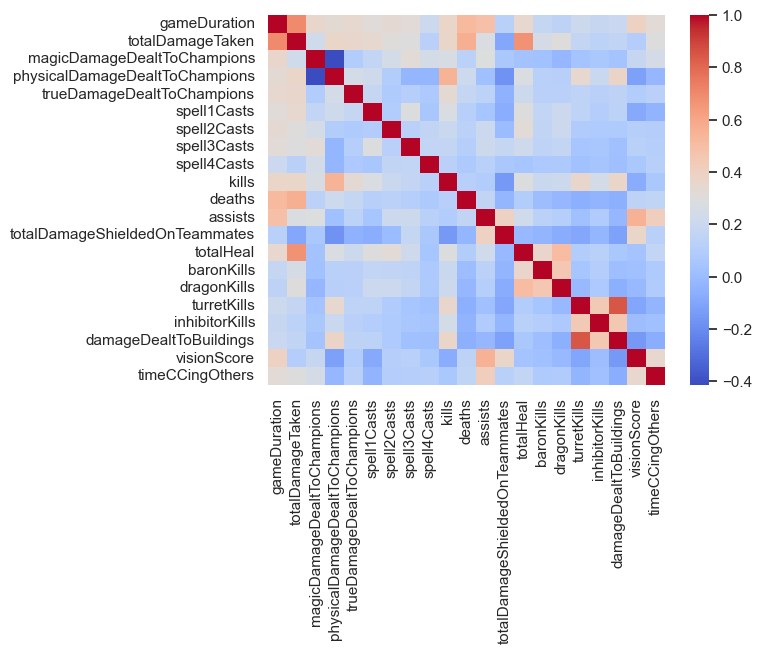

In [60]:
corr = df[['gameDuration', 'totalDamageTaken', 'magicDamageDealtToChampions',
    'physicalDamageDealtToChampions', 'trueDamageDealtToChampions',
      'spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts',
      'kills', 'deaths','assists',
      'totalDamageShieldedOnTeammates','totalHeal',
      'baronKills', 'dragonKills', 'turretKills', 'inhibitorKills', 'damageDealtToBuildings',
      'visionScore', 'timeCCingOthers'
      ]].corr()

sns.heatmap(corr, cmap = 'coolwarm' )

Know from playing the game that champions usually have an intended lane to play

In [61]:
df[['championName', 'lane']].value_counts()

championName  lane  
MissFortune   BOTTOM    5438
Smolder       BOTTOM    4857
Jhin          BOTTOM    4617
Senna         BOTTOM    3942
Caitlyn       BOTTOM    3844
                        ... 
Olaf          BOTTOM       3
Viktor        JUNGLE       2
Renata        TOP          2
Braum         JUNGLE       2
Hecarim       MIDDLE       1
Name: count, Length: 835, dtype: int64

# Items

In [62]:
items = ['item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6']
for item in items:
    print(df[['championName', item]].value_counts()[:5])

championName  item0               
Lux           Zaz'Zak's Realmspike    2371
Senna         Bloodsong               1926
Zyra          Zaz'Zak's Realmspike    1626
Caitlyn       Doran's Blade           1506
MissFortune   Youmuu's Ghostblade     1416
Name: count, dtype: int64
championName  item1              
Smolder       Essence Reaver         2396
MissFortune   Youmuu's Ghostblade    2251
Yone          Berserker's Greaves    1729
Yasuo         Berserker's Greaves    1685
Jhin          Youmuu's Ghostblade    1575
Name: count, dtype: int64
championName  item2                   
Smolder       Ionian Boots of Lucidity    1901
Jhin          Boots of Swiftness          1788
Lux           Sorcerer's Shoes            1776
Caitlyn       Berserker's Greaves         1706
Brand         Sorcerer's Shoes            1494
Name: count, dtype: int64
championName  item3                   
MissFortune   The Collector               1467
Smolder       Navori Quickblades          1389
Jhin          The Col

# Damage

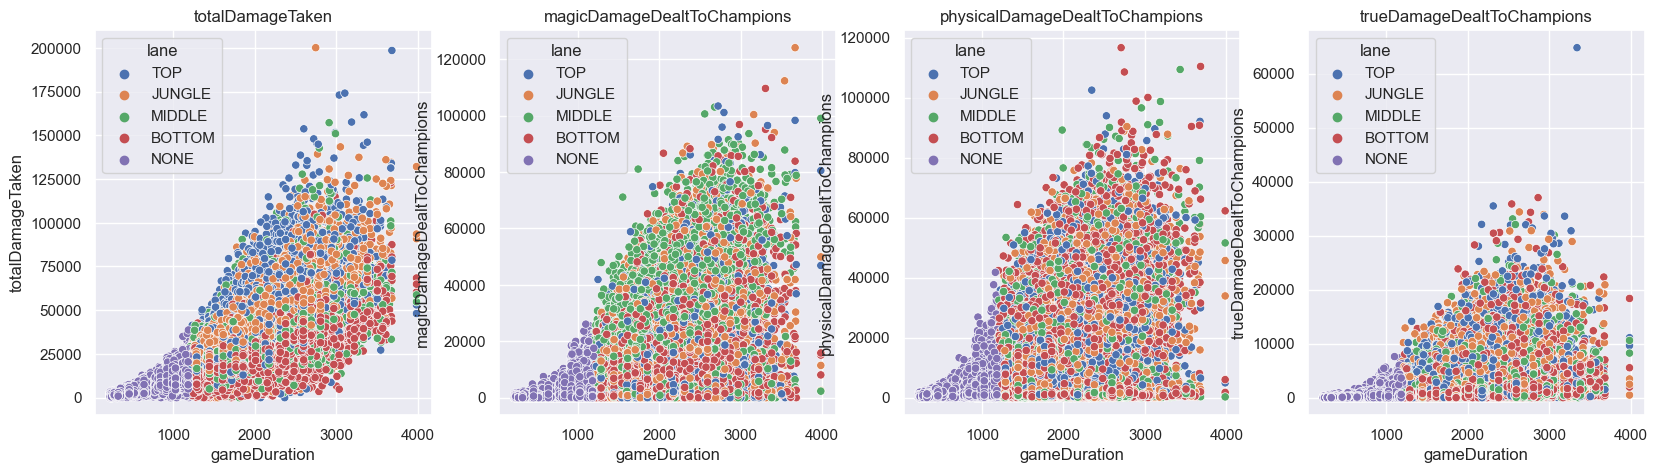

In [63]:
damage = ['totalDamageTaken', 'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions']
fig, axs = plt.subplots(1, len(damage), figsize=(20, 5))
for i, feature in enumerate(damage):
    sns.scatterplot(data = df, x = 'gameDuration', y = feature, hue = 'lane', ax = axs[i])
    axs[i].set_title(feature)


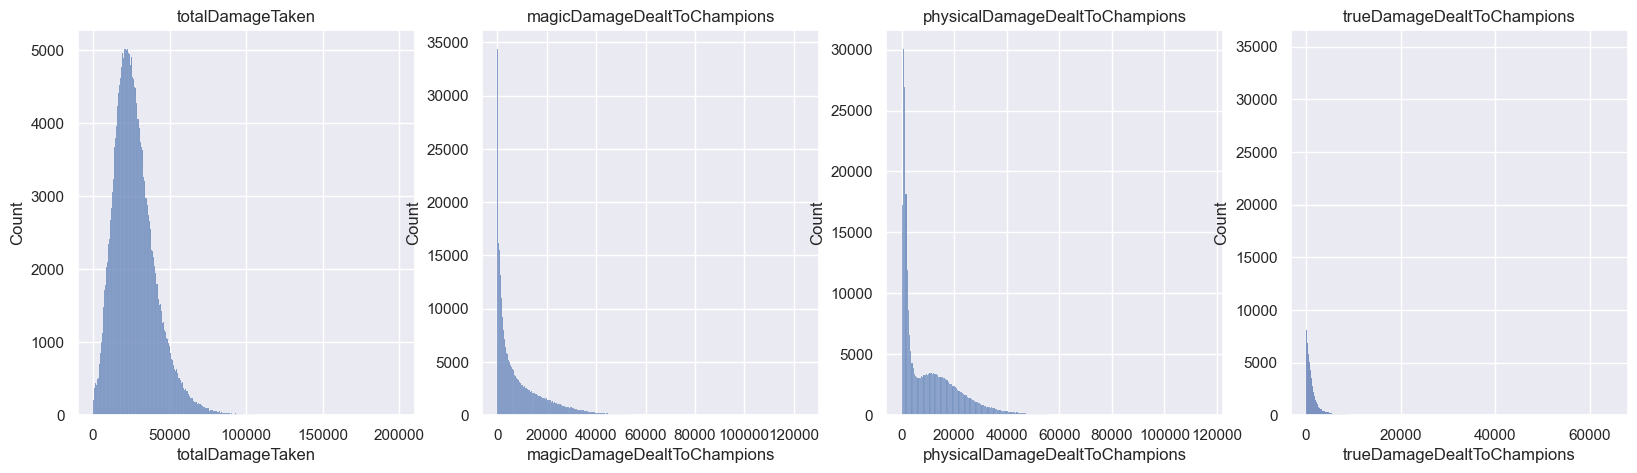

In [64]:
damage = ['totalDamageTaken', 'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions']
fig, axs = plt.subplots(1, len(damage), figsize=(20, 5))
for i, feature in enumerate(damage):
    sns.histplot(data = df, x = feature, ax = axs[i])
    axs[i].set_title(feature)


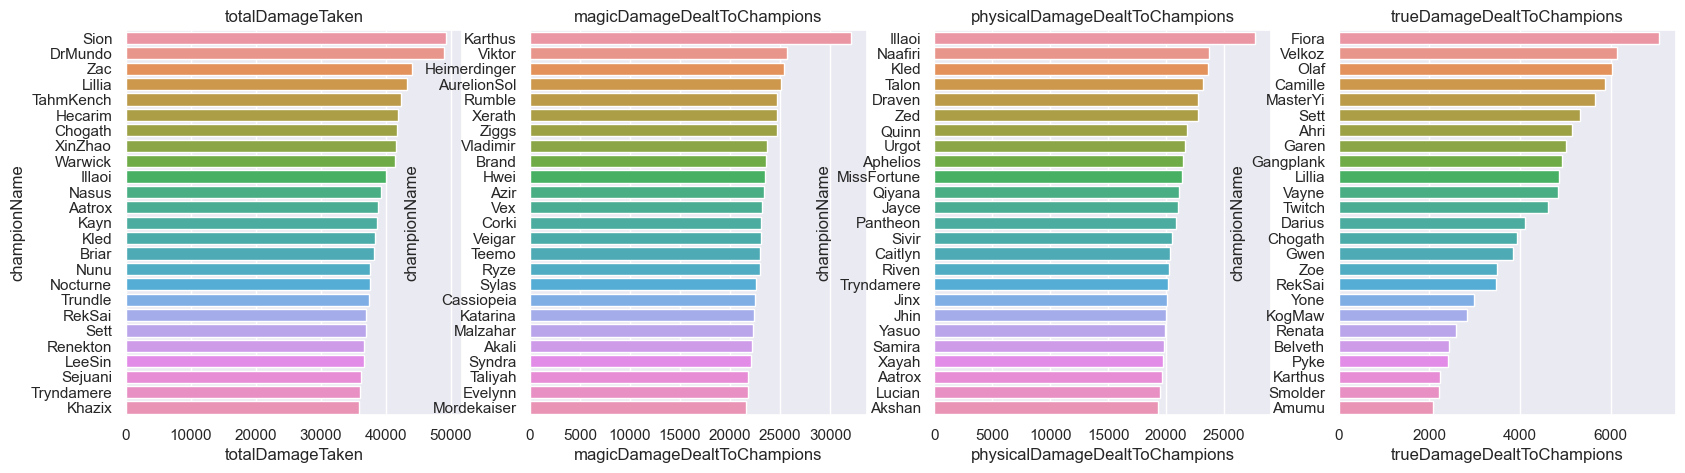

In [65]:
damage = ['totalDamageTaken', 'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions']

fig, axs = plt.subplots(1, len(damage), figsize=(20, 5))
for i, feature in enumerate(damage):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)


# Healing/Shielding

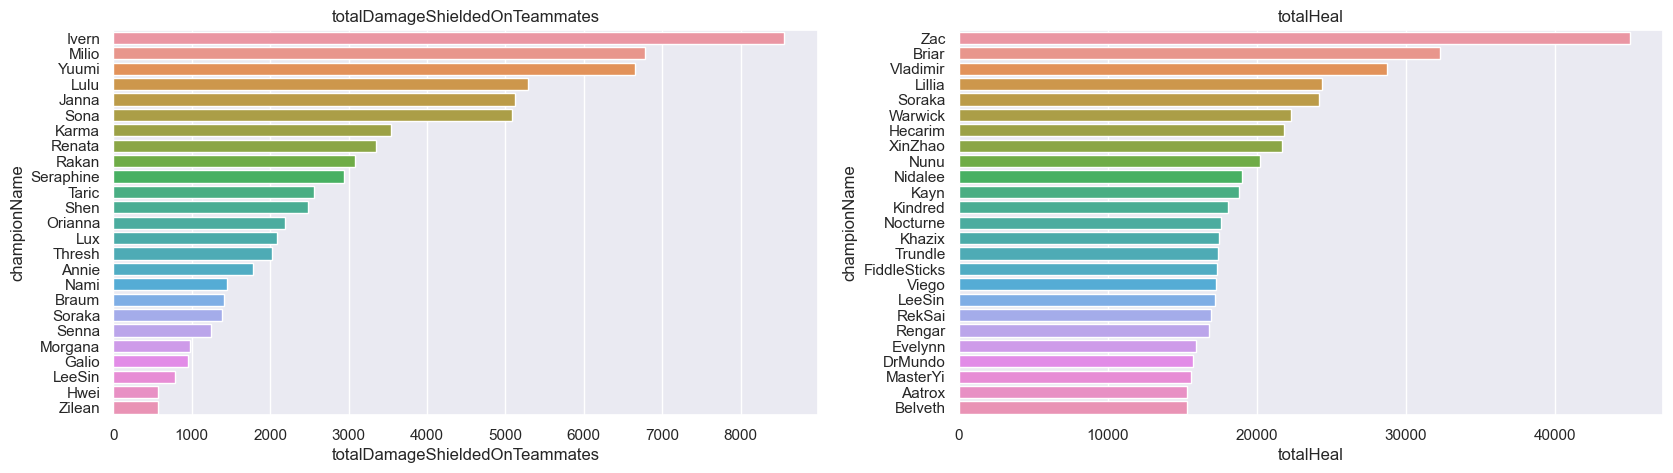

In [66]:
heal_shield = ['totalDamageShieldedOnTeammates','totalHeal']

fig, axs = plt.subplots(1, len(heal_shield), figsize=(20, 5))
for i, feature in enumerate(heal_shield):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)


# Objectives

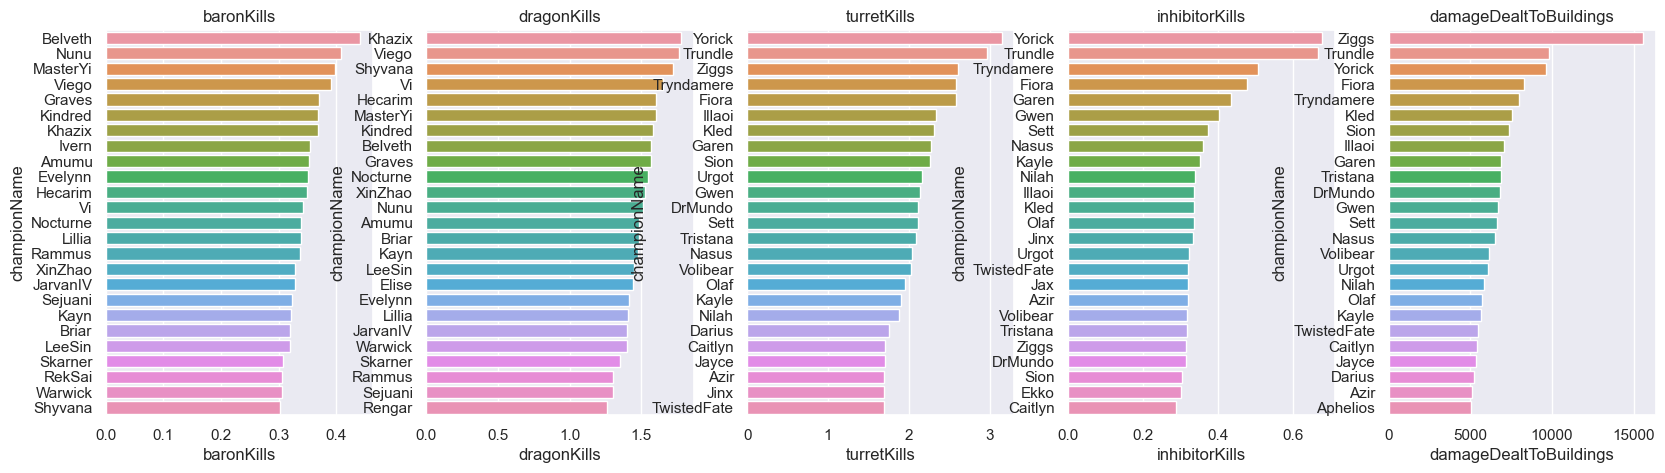

In [67]:
objectives = ['baronKills', 'dragonKills', 'turretKills', 'inhibitorKills', 'damageDealtToBuildings']

fig, axs = plt.subplots(1, len(objectives), figsize=(20, 5))
for i, feature in enumerate(objectives):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)


# Vision + CC

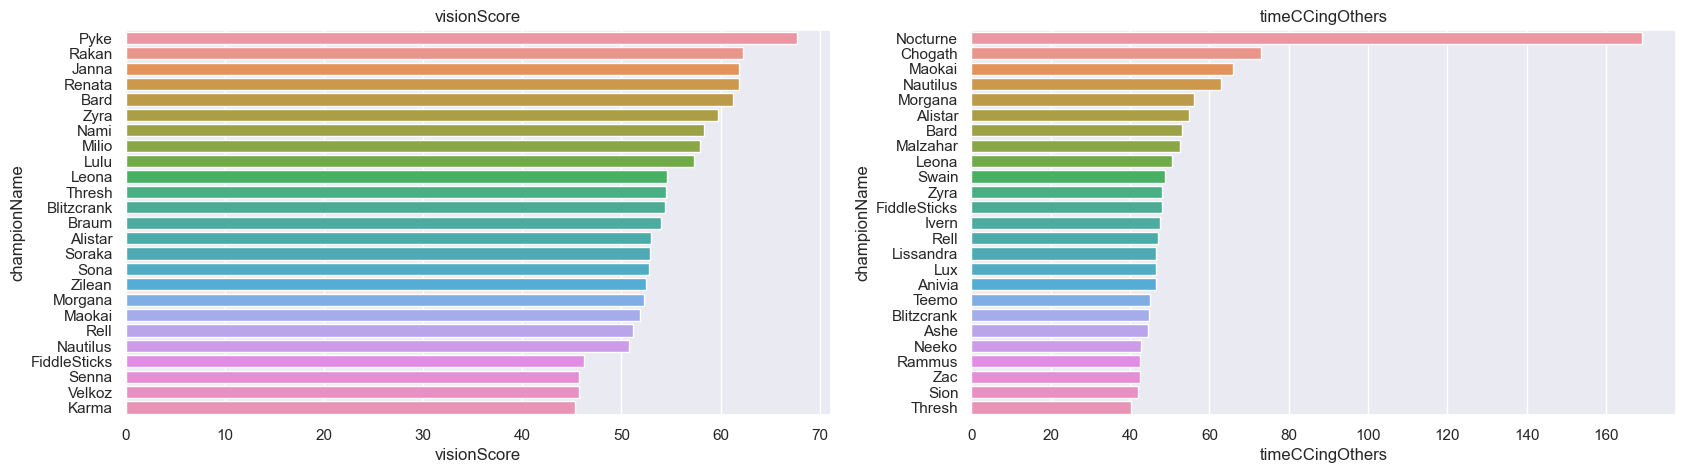

In [68]:
other = ['visionScore', 'timeCCingOthers']

fig, axs = plt.subplots(1, len(other), figsize=(20, 5))
for i, feature in enumerate(other):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)


Supports generally have higher vision score, heavy cc champions have most time ccing others with nocturne at no. 1 spot since his ult blinds everyone for 5 seconds.

# Spells Casted

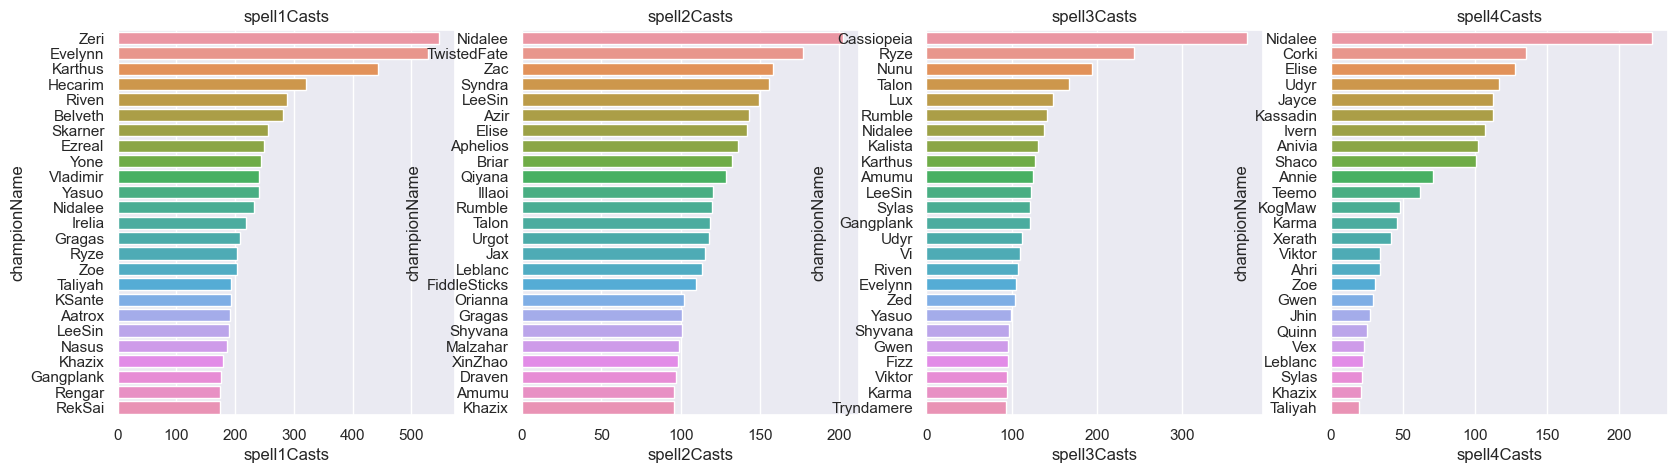

In [69]:
spells = ['spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts']

fig, axs = plt.subplots(1, len(spells), figsize=(20, 5))
for i, feature in enumerate(spells):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)


Q spam champions have most spell 1 casts (Zeri, Evelynn, Karthus, Hecarim etc.)
W spam -> Nidalee jump, twisted fate card, 
E spam -> Cass fangs, ryze eq combo, nunu snowball, talon jump
R spam -> mostly transform champions + corki rocket and kassdin teleport

We see that certain champions definitely cast certain spells much more than others

# Summoner Spells

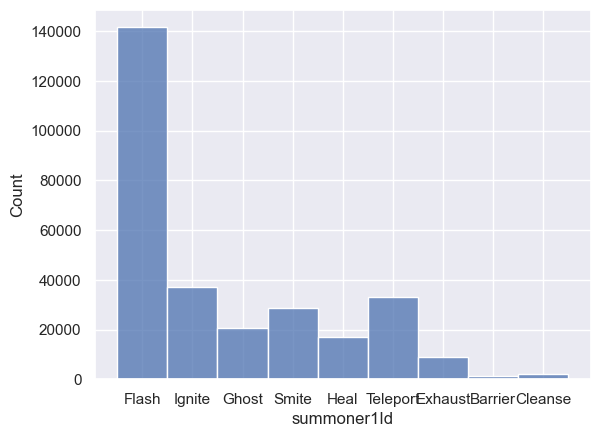

In [70]:
sns.histplot(data = df, x = 'summoner1Id')


# Summoner spells by lane

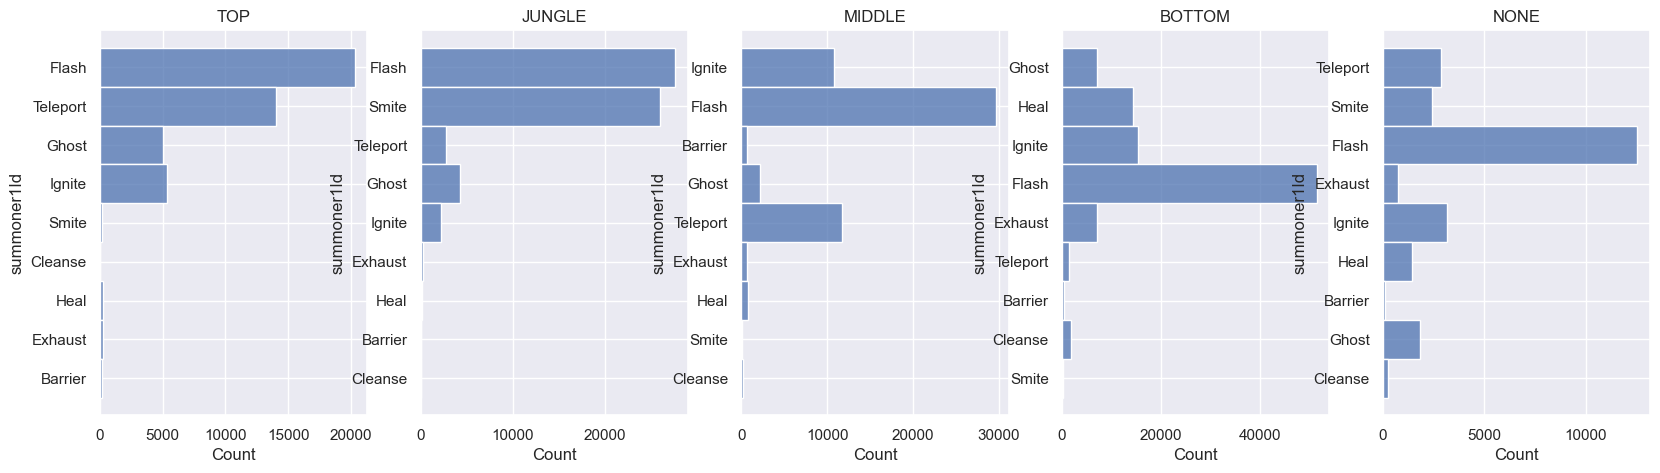

In [71]:
lanes = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'NONE']

fig, axs = plt.subplots(1, len(lanes), figsize=(20, 5))
for i, feature in enumerate(lanes):
    sns.histplot(data = df[df['lane'] == feature], y = 'summoner1Id', ax = axs[i])
    axs[i].set_title(feature)

In [345]:
df[['summoner1Id','summoner2Id']][df['championName'] == 'Singed'].value_counts()

summoner1Id  summoner2Id
Ghost        Flash          150
Flash        Ghost          145
Teleport     Ghost           75
Ghost        Teleport        63
             Ignite          53
Ignite       Ghost           32
Smite        Ghost           18
Ghost        Smite           16
Flash        Ignite          12
             Teleport        11
Ignite       Flash            7
Flash        Smite            4
Smite        Flash            4
Teleport     Flash            4
Ghost        Barrier          1
             Heal             1
Flash        Heal             1
Heal         Flash            1
Exhaust      Ignite           1
Name: count, dtype: int64

In [346]:
df['lane'].value_counts()

lane
BOTTOM    66235
JUNGLE    42466
MIDDLE    37820
TOP       30319
NONE      16910
Name: count, dtype: int64

In [347]:
df['role'].value_counts()

role
SOLO       58874
SUPPORT    49527
NONE       42466
CARRY      32429
DUO        10454
Name: count, dtype: int64

In [348]:
df['teamPosition'].value_counts()

teamPosition
TOP        38744
MIDDLE     38744
JUNGLE     38743
BOTTOM     38739
UTILITY    38737
              43
Name: count, dtype: int64

# Feature Engineering
1. Normalize certain features by game duration
2. Classify champions as AD/AP
3. Classify champions as their class based on itemization?


For sake of simplicity, I am going to address the three features 'role', 'lane', and 'teamPosition' by just simplifying them into one feature where I redefine their lane which can be either 1. TOP 2. JUNGLE 3. MIDDLE 4. ADC 5. SUPPORT to follow traditional League of Legends team compositions

In [12]:
# Normalize games by duration so features on a per second basis (ex. total damage taken per second)
def game_normalize_by_duration(feature_list):
    for feature in feature_list:
        df[feature] = df[feature] / df['gameDuration']

    return df

# Combining Objective kills and Building Kills
df['objective_kills'] = df['dragonKills'] + df['baronKills']
df['building_kills'] = df['turretKills'] + df['inhibitorKills']

feature_list = ['totalDamageTaken', 'magicDamageDealtToChampions',
  'physicalDamageDealtToChampions', 'trueDamageDealtToChampions',
  'totalDamageShieldedOnTeammates','totalHeal',
  'spell1Casts', 'spell2Casts',
    'spell3Casts', 'spell4Casts',
    'visionScore', 'timeCCingOthers',
    'objective_kills', 'building_kills'
  ]

# Normalize all continuous features by game duration
df = game_normalize_by_duration(feature_list)

# Classifying champions as ap champs if they deal more magic than physical damage
df['ap'] = (df['physicalDamageDealtToChampions'] < df['magicDamageDealtToChampions']).astype(int)

# Same thing for ad
df['ad'] = (df['physicalDamageDealtToChampions'] > df['magicDamageDealtToChampions']).astype(int)


Class classification:
Enchanter -> Heal and shield
Catcher -> lots of cc
Juggernaut -> tanky but also deal damage
Diver -> kill backline
Burst mages -> Huge amount of AP damage quickly
Battle mages -> Sustained damage over huge area
Artillery -> poke damage
Marksmen -> damage carries, adcs usually
Assassin -> Huge AD damage quickly
Skirmisher -> Duelists -> excel in 1v1
Tank -> absorb most damage 

## ML Pipeline

In [13]:
# Import ML libs
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix


In [14]:
# Filter for important features
important_features = ['lane', 'championName', 'ap', 'ad', 'spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts','totalDamageTaken', 'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions','totalDamageShieldedOnTeammates','totalHeal', 'visionScore', 'timeCCingOthers', 'objective_kills', 'building_kills']
df = df[important_features]

In [15]:
# Seperate target from features
X = df.drop(columns = ['championName'])
y = df['championName']

# Split train/test
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Seperate numeric and categorical features
num_features = X.select_dtypes(include=['float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# KNN
k = 5
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors = k))
])

# SVM
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

# Naive-Bayes
nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Logistic Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [16]:
pipelines = {'Random Forest': rf_pipeline,
             'K Nearest Neighbours': knn_pipeline,
             'Support Vector Machines': svm_pipeline,
             'Naive-Bayes': nb_pipeline,
             'Logistic Regression': lr_pipeline
             }

# Evaluating Models

In [17]:
for model, pipeline in pipelines.items():
    pipeline.fit(train_X, train_y)
    preds = pipeline.predict(val_X)
    accuracy = accuracy_score(val_y, preds)
    precision = precision_score(y_pred = preds, y_true = val_y, average = 'weighted')
    recall = recall_score(y_pred = preds, y_true = val_y, average = 'weighted')
    f1 = f1_score(y_pred = preds, y_true = val_y, average = 'weighted')
    
    print('Model: %s' % model)
    print('Accuracy: %.3f' % accuracy)
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('F1 Score: %.3f' % f1)
    print('--------------------')

Model: Random Forest
Accuracy: 0.936
Precision: 0.936
Recall: 0.936
F1 Score: 0.936
--------------------
Model: K Nearest Neighbours
Accuracy: 0.853
Precision: 0.857
Recall: 0.853
F1 Score: 0.852
--------------------
Model: Support Vector Machines
Accuracy: 0.930
Precision: 0.930
Recall: 0.930
F1 Score: 0.929
--------------------
Model: Naive-Bayes
Accuracy: 0.703
Precision: 0.775
Recall: 0.703
F1 Score: 0.699
--------------------


c:\Users\toirt\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.901
Precision: 0.901
Recall: 0.901
F1 Score: 0.900
--------------------


## Cross-validation to ensure RF model is not overfit

In [13]:
rf_scores = cross_val_score(rf_pipeline, X, y, cv = 5)
print('Cross-val accuracy average: ' + str(np.mean(rf_scores)))

Cross-val accuracy average: 0.9284911579165087


In [14]:
np.std(rf_scores)

0.0013915957059372716